In [28]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# Load the Excel file into a DataFrame
file_path = 'NZIP-outputs-BP.xlsx'  # Replace with your file's path
df = pd.read_excel(file_path)

In [64]:
filtered_df = df[["Process", "Element_sector", "Dispersed or Cluster Site"] + 
                [col for col in df.columns if col.startswith("Remaining direct emissions per year (MtCO2e) 20")
                 and int(col.split()[-1]) >= 2021 and int(col.split()[-1]) <= 2050]].copy()

new_column_names = {}
for col in filtered_df.columns:
    if col.startswith("Remaining direct emissions per year (MtCO2e) 20"):
        year = col.split()[-1]
        new_column_names[col] = year

filtered_df = filtered_df.rename(columns=new_column_names)

sector_map_df = pd.read_csv('nzip_model_sector_map.csv', usecols=['EE Sector', 'CCC Subsector'])
sector_map = dict(zip(sector_map_df['EE Sector'], sector_map_df['CCC Subsector']))
filtered_df['Element_sector'] = filtered_df['Element_sector'].map(sector_map)

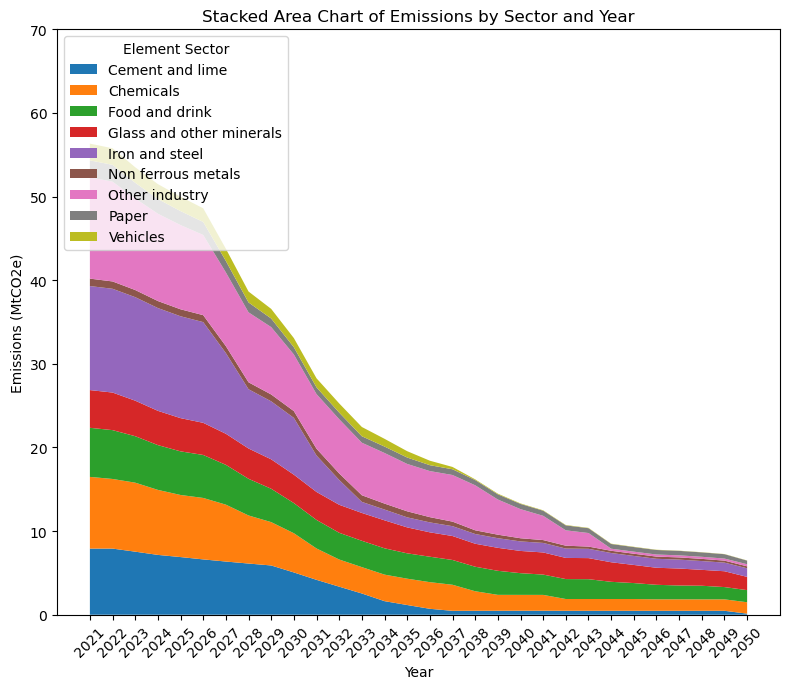

In [105]:
columns_to_keep = ['Element_sector'] + [str(year) for year in range(2021, 2051)]
filtered_df = filtered_df[columns_to_keep].copy()

for col in filtered_df.columns:
    if col != 'Element_sector':
        filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')

plot_data = filtered_df.melt(id_vars=['Element_sector'], 
                             var_name='Year', 
                             value_name='Emissions')

pivot_data = plot_data.pivot_table(index='Year', 
                                   columns='Element_sector', 
                                   values='Emissions', 
                                   aggfunc='sum')

pivot_data_transposed = pivot_data.T
plt.figure(figsize=(8, 7))
plt.stackplot(pivot_data_transposed.columns, pivot_data_transposed, labels=pivot_data_transposed.index)
plt.title('Stacked Area Chart of Emissions by Sector and Year')
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO2e)')
plt.ylim(0, 70)
plt.xticks(rotation=45)
plt.legend(loc='upper left', title='Element Sector')
plt.tight_layout()
plt.show()

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

filtered_df = df[["Process", "Element_sector", "Dispersed or Cluster Site"] + 
                [col for col in df.columns if col.startswith("Remaining direct emissions per year (MtCO2e) 20")
                 and int(col.split()[-1]) >= 2021 and int(col.split()[-1]) <= 2050]].copy()

new_column_names = {}
for col in filtered_df.columns:
    if col.startswith("Remaining direct emissions per year (MtCO2e) 20"):
        year = col.split()[-1]
        new_column_names[col] = year

filtered_df = filtered_df.rename(columns=new_column_names)

sector_map_df = pd.read_csv('nzip_model_sector_map.csv', usecols=['EE Sector', 'CCC Subsector'])
sector_map = dict(zip(sector_map_df['EE Sector'], sector_map_df['CCC Subsector']))
filtered_df['Element_sector'] = filtered_df['Element_sector'].map(sector_map)

df_long = filtered_df.melt(id_vars=['Dispersed or Cluster Site', 'Element_sector', 'Process'],
                  var_name='Year',
                  value_name='Emissions')

df_long = df_long[(df_long['Year'].astype(int) >= 2045) & (df_long['Year'].astype(int) <= 2050)]

total_emissions_by_process = df_long.groupby('Process')['Emissions'].sum()

top_processes = total_emissions_by_process.nlargest(15).index

df_long['Process_Categorized'] = df_long['Process'].apply(lambda x: x if x in top_processes else 'Other')

pivot_df = df_long.pivot_table(index='Year', columns='Process_Categorized', values='Emissions', aggfunc='sum')

pivot_df = pivot_df[[col for col in pivot_df.columns if col != 'Other'] + ['Other']]

distinctive_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666',
    'grey'  # for 'Other'
]

colors = distinctive_colors[:len(pivot_df.columns)]

fig, ax = plt.subplots(figsize=(8, 7))
baseline = np.zeros(len(pivot_df))
for col, color in zip(pivot_df.columns, colors):
    ax.fill_between(pivot_df.index, baseline, baseline + pivot_df[col], label=col, color=color)
    baseline += pivot_df[col].fillna(0)

plt.title('Stacked Area Chart of Emissions by Process')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.ylim(0, 10)
plt.xticks(rotation=45) 
plt.legend(loc='upper left')
pivot_df.to_excel("residuals_by_process.xlsx")
plt.show()

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

filtered_df = df[["Process", "Element_sector", "Dispersed or Cluster Site"] + 
                [col for col in df.columns if col.startswith("Remaining direct emissions per year (MtCO2e) 20")
                 and int(col.split()[-1]) >= 2021 and int(col.split()[-1]) <= 2050]].copy()

new_column_names = {}
for col in filtered_df.columns:
    if col.startswith("Remaining direct emissions per year (MtCO2e) 20"):
        year = col.split()[-1]
        new_column_names[col] = year

filtered_df = filtered_df.rename(columns=new_column_names)

sector_map_df = pd.read_csv('nzip_model_sector_map.csv', usecols=['EE Sector', 'CCC Subsector'])
sector_map = dict(zip(sector_map_df['EE Sector'], sector_map_df['CCC Subsector']))
filtered_df['Element_sector'] = filtered_df['Element_sector'].map(sector_map)

df_long = filtered_df.melt(id_vars=['Dispersed or Cluster Site', 'Element_sector', 'Process'],
                  var_name='Year',
                  value_name='Emissions')

total_emissions_by_sector_process = df_long.groupby(['Element_sector', 'Process'])['Emissions'].sum()

pivot_df_element_sector = df_long.pivot_table(
    index='Year', columns='Element_sector', values='Emissions', aggfunc='sum'
)

all_years = [str(year) for year in range(2045, 2051)]  #Change year data to zoom in or out of the plot
pivot_df_element_sector = pivot_df_element_sector.reindex(all_years, fill_value=0)

distinctive_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666',
    'grey'  # for 'Other'
]

colors = distinctive_colors[:len(pivot_df_element_sector.columns)]

fig, ax = plt.subplots(figsize=(15, 7)) 
baseline = np.zeros(len(pivot_df_element_sector))
for col, color in zip(pivot_df_element_sector.columns, colors):
    ax.fill_between(pivot_df_element_sector.index, baseline, baseline + pivot_df_element_sector[col], label=col, color=color)
    baseline += pivot_df_element_sector[col].fillna(0)

plt.title('Stacked Area Chart of Emissions by Element Sector')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()